# Protein deep learning

Although proteins are more of an interest for bioinformaticians than for cheminformaticians, they are a crucial element of drug design. Especially the 3D structure of proteins is very important because of its connection to the functioning of these biological machines in the organism.

## Protein representations

Proteins are chemical compounds, but considering their huge volume, they are often processed in a different way than small molecules. Typical representations are:

1. **Amino acid sequence** - proteins are strings of amino acids that can be represented as text, and by adding information about dihedral angles we can encode spatial information; we can process this representation using recurrent neural networks or transformers;
![dihedrals](https://upload.wikimedia.org/wikipedia/commons/c/c0/Protein_backbone_PhiPsiOmega_drawing.jpg)
2. **Graphs** - this representation is similar to molecular graphs known from the previous notebooks, but in this case to simplify the structure, only α carbons are represented encoding their amino acid residue; this representation can be processed using graph neural networks;
3. **Voxel grids** - this representation is constructed by surrounding the protein with a voxel grid (cubes that encode atoms they intersect); usually the voxel size can be set to 1 Å^3 (1 Å = 10^-10 m); this representation can be processed using 3D convolutional neural networks;
![voxel](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0221347.g002&type=large)
4. **Distance or contact maps** - two-dimensional representation that represents distances between alpha carbons; we can binarize these distances using a selected threshold value, and such maps are called contact maps; this representation can be processed using (2D) convolutional neural networks;
![contact](https://upload.wikimedia.org/wikipedia/commons/8/8d/Protein_Contact_Map%2C_2-Color%2C_2QIP-A.png)
5. **Point clouds** - sets of not connected points (alpha carbons) encoding selected features (e.g. amino acid codes); this representation can be processed by neural networks adapted to processing point clouds, which are similar to graph neural networks;
6. **Meshes** - in this representation we only encode features of the protein surface; a graph is constructed by sampling a grid of points on the surface of proteins (a mesh), and the nodes can encode features related to the amino acids in the vicinity; this representation can be processed by graph neural networks.

## Problems that can be solved

1. **Inverse protein folding**, also known as protein design - a task that aims to find an amino acid sequence that folds to a given 3D structure;
2. **Binding site detection** - discovering cavities in proteins that can be used as binding sites for ligands; it can be realized as 3D grid segmentation using 3D convolutions (e.g. U-Net);
3. **Binding affinity prediction** - evaluation of the binding affinity given the ligand-protein complex (e.g. a ligand docked to the crystal structure of a protein).
4. **protein-based *de novo* design** - designing new ligands that match the binding site of a given protein.
![deepsite](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSv_unCC0dhDSQWwQipcKQSEulT064aq-WOnQ&usqp=CAU)

**Exercise 1:** Implement one of the representations above (the code below can be used to implement 3D voxel grids).

## Przykładowy fragment implementacji wokseli

In [2]:
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [3]:
symbols = ['C', 'N', 'O', 'S']

In [5]:
# Load protein from a PDB file
mol = Chem.MolFromPDBFile('4ivt.pdb')
# Create a position matrix of dimensions number_of_atoms x 3
pos = mol.GetConformer().GetPositions() 
print(pos)
# Create a bounding box definition, e.g. two corners of the protein bounding box
lower_bound = pos.min(axis=0) 
upper_bound = pos.max(axis=0)
# Calculate bounding box size (you can use 1 unit as the voxel size)
box_size = np.ceil(upper_bound - lower_bound).astype(int)
# Create an empty grid with 4 channels (number of symbols) and size corresponding to the bounding box
grid = np.zeros([*box_size, 4])  

[[ 9.527 19.931 33.672]
 [10.971 20.    33.868]
 [11.442 21.45  33.989]
 ...
 [37.518 41.778 -0.514]
 [38.621 43.221  1.277]
 [38.44  42.432 -1.517]]


In [6]:
for i, atom in enumerate(mol.GetAtoms()):
    # Map atoms onto the grid, use 1 to mark the corresponding grid position and channel
    # tip: you will need the atom symbol and atom position aligned with the grid
    symbol = atom.GetSymbol()
    position = np.floor(pos[i] - lower_bound).astype(int)
    grid[position[0], position[1], position[2], symbols.index(symbol)] = 1.0

<IPython.core.display.Javascript object>


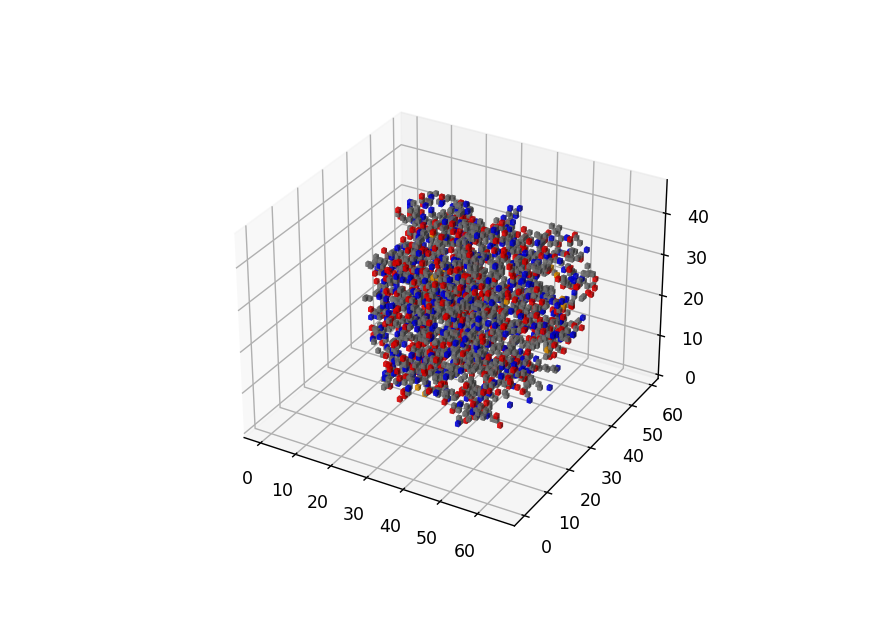

In [7]:
# The code below will plot your voxel grid
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(grid[:, :, :, 0], facecolors='grey', alpha=0.7)
ax.voxels(grid[:, :, :, 1], facecolors='blue', alpha=0.7)
ax.voxels(grid[:, :, :, 2], facecolors='red', alpha=0.7)
ax.voxels(grid[:, :, :, 3], facecolors='orange', alpha=0.7)
plt.show()

**Exercise 2:** Implement a network that processes this representation (you don't need to train it, it should only return a correct output). In the case of voxel grids: check if your voxel grid can be passed through a 3D convolution (imported from PyTorch), and the output shape is what you expected.

In [11]:
import torch
from torch.nn import Conv3d, ELU, MaxPool3d, Dropout3d, Flatten, Linear, Softmax

model = torch.nn.Sequential(
    Conv3d(in_channels=4, out_channels=16, kernel_size = 8, padding = 2),
    ELU(), 
    Conv3d(in_channels=16, out_channels=32, kernel_size = 8, padding = 1),
    ELU(), 
    MaxPool3d(kernel_size=2),
    Dropout3d(0.25), 
    Flatten(),
    Linear(in_features = 2048, out_features = 256),
    ELU(),
    Linear(in_features = 256, out_features = 5),
    ELU(),
    Softmax()                 
)

x = torch.FloatTensor(grid[:16, :16, :16, :]).unsqueeze(0).movedim(4, 1)
print(model(x).shape)

torch.Size([1, 5])
